# Data Analysis

## Importing libraries and documents

In [1]:
import pandas as pd
import numpy as np
import regex as re
import emoji
import string
from tqdm.notebook import tqdm

import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from PIL import Image
from wordcloud import WordCloud

In [22]:
df = pd.read_csv("../reviews_scores.csv", index_col=0)

In [24]:
# Arranging the comp score column! NEED TO DELETE LATER!
df['comp_score'] = df['compound'].apply(lambda c: "positive" if c >= 0.2 else ("neutral" if c >= -0.2 and (c <= 0.2) else "negative"))

## Dataset description

The dataset contains 55568 instances and 6 features:
- `rating`: evaluation of user visit from 1 to 5
- `title`: title of the review
- `review_body`: body of the user review
- `date`: date of the visit 
- `country`: country of the user
- `sentiment_value`: human label
- `scores`: scores given by the SentimentIntensityAnalyzer module
- `compound`: is the summary score of the previous column. Ranges from -1 (most negative) to 1 (most positive)
- `comp_score`: machine label

In [25]:
df.head(5)

,rating,title,review_body,date,country,sentiment_value,scores,compound,comp_score
0,5,Birthday week,An amazing once in a lifetime experience. You ...,2019 December,United States,positive,"{'neg': 0.0, 'neu': 0.73, 'pos': 0.27, 'compou...",0.9866,positive
1,5,You must visit it!,"Whatever I say, it can't describe this archite...",2020 June,Georgia,positive,"{'neg': 0.0, 'neu': 0.84, 'pos': 0.16, 'compou...",0.6580,positive
2,5,Amazing Masterpiece,It is impossible to describe the greatness of ...,2019 December,United States,positive,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
3,5,Incredible building,"An absolutely stunning building, still in the ...",2019 December,France,positive,"{'neg': 0.142, 'neu': 0.573, 'pos': 0.286, 'co...",0.6989,positive
4,5,Gaudi a true Genius!!,Gaudi was an Architectural Legend! Once this ...,2020 November,United Kingdom,positive,"{'neg': 0.123, 'neu': 0.773, 'pos': 0.104, 'co...",-0.2187,negative


Taking a look into the features types, it can be observed that most of them are categorical features except rating, which is an integer. On the other side, the `date` column needs to be tranformed to a datetime type:

In [26]:
df.dtypes

rating               int64
title               object
review_body         object
date                object
country             object
sentiment_value     object
scores              object
compound           float64
comp_score          object
dtype: object

In [27]:
df["date"] = pd.to_datetime(df['date'], format="%Y %B")

### Datetime approach exploration

TripAdvisor is a website which has been growing over the last decade. Therefore, the number of opinions has been increasing. The graph below shows the yearly distribution of the english reviews.

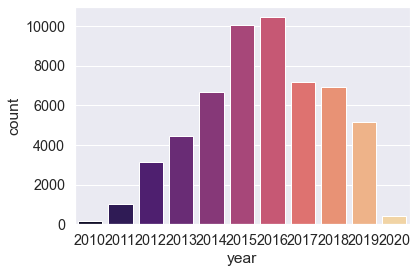

In [28]:
# Creating a DataFrame to show the distribution of reviews per age
# Extracting year from datetime column
df['year'] = df['date'].dt.to_period('Y')
years = pd.DataFrame(df['year'].groupby([df.year]).agg({'count'})).reset_index()
sns.barplot(x="year", y="count", data=years, palette="magma")

Text(0.5, 1.0, 'Monthly average rating 2014-2018')

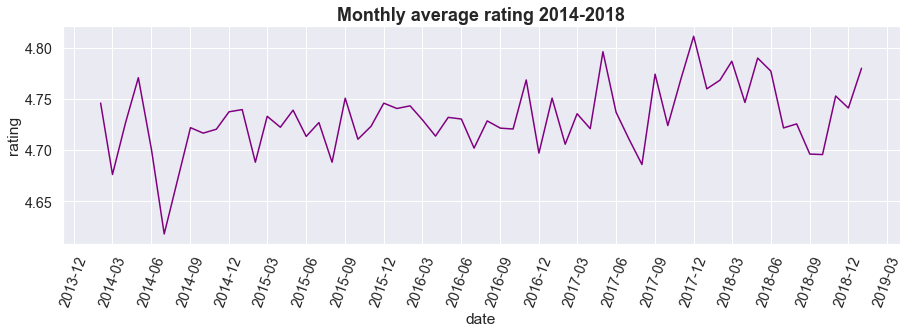

In [29]:
# Creating monthly dataframe with average rating per month
monthly_rating = df.groupby("date")[["rating"]].mean().reset_index()


# Creating a mask to plot the years with most reviews
mask = (monthly_rating['date'] > "2014-01-01") & (monthly_rating['date'] <= "2019-01-01")
monthly_14_18 = monthly_rating.loc[mask]

# Ploting the evolution of ratings
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,1,1)
sns.lineplot(data=monthly_14_18, x="date", y="rating", color="purple")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) #Changing the xticks to trimestral freq
plt.xticks(rotation=70)
plt.title("Monthly average rating 2014-2018", fontsize=18, weight='bold')

In [31]:
# Creating dataframe with counter of number of reviews per year per sentiment value
datetime_positive = pd.DataFrame(df[df['sentiment_value'] == 'positive'].groupby([df.year])["sentiment_value"].count())
datetime_negative = pd.DataFrame(df[df['sentiment_value'] == 'negative'].groupby([df.year])["sentiment_value"].count())
datetime_neutral = pd.DataFrame(df[df['sentiment_value'] == 'neutral'].groupby([df.year])["sentiment_value"].count())
count = pd.DataFrame(df['year'].groupby([df.year]).agg({'count'}))

# Concatenating all the dataframes created above
year_sentiment = pd.concat([datetime_positive, datetime_neutral, datetime_negative, count], axis=1, sort=False)
year_sentiment.columns = ["positive_sentiment", "neutral_sentiment", "negative_sentiment", "total"] #Renaming columns

# Creating columns with percentages
year_sentiment["positive_percentage"] = round((year_sentiment["positive_sentiment"])*100 /year_sentiment["total"],2)
year_sentiment["neutral_percentage"] = round((year_sentiment["neutral_sentiment"])*100 /year_sentiment["total"],2)
year_sentiment["negative_percentage"] = round((year_sentiment["negative_sentiment"])*100 /year_sentiment["total"],2)
year_sentiment

,positive_sentiment,neutral_sentiment,negative_sentiment,total,positive_percentage,neutral_percentage,negative_percentage
year,,,,,,,
2010,111,19,22,152,73.03,12.50,14.47
2011,954,41,8,1003,95.11,4.09,0.80
2012,3000,132,25,3157,95.03,4.18,0.79
2013,4239,173,53,4465,94.94,3.87,1.19
2014,6265,288,93,6646,94.27,4.33,1.40
2015,9494,411,120,10025,94.70,4.10,1.20
2016,9859,434,141,10434,94.49,4.16,1.35
2017,6810,259,106,7175,94.91,3.61,1.48
2018,6553,254,107,6914,94.78,3.67,1.55


#### Geopraphical analysis of the reviews

In [32]:
positive_countries = pd.DataFrame(df[df['sentiment_value'] == 'positive'].groupby([df.country])["sentiment_value"].count())
neutral_countries = pd.DataFrame(df[df['sentiment_value'] == 'neutral'].groupby([df.country])["sentiment_value"].count())
negative_countries = pd.DataFrame(df[df['sentiment_value'] == 'negative'].groupby([df.country])["sentiment_value"].count())
total = pd.DataFrame(df['country'].groupby([df.country]).agg({'count'}))

# Concatenating all the dataframes created above
countries_sentiment = pd.concat([positive_countries, neutral_countries, negative_countries, total], axis=1, sort=False)
countries_sentiment.columns = ["positive_reviews", "neutral_reviews", "negative_reviews", "total"] #Renaming columns

# Creating columns with percentages
countries_sentiment["positive_percentage"] = round((countries_sentiment["positive_reviews"])*100 /countries_sentiment["total"],2)
countries_sentiment["neutral_percentage"] = round((countries_sentiment["neutral_reviews"])*100 /countries_sentiment["total"],2)
countries_sentiment["negative_percentage"] = round((countries_sentiment["negative_reviews"])*100 /countries_sentiment["total"],2)
countries_sentiment = countries_sentiment.fillna(0)

In [33]:
#Droping the row "Others" as is not any country and saving file to csv for Tableau
countries_sentiment = countries_sentiment.drop("Others")
countries_sentiment.to_csv("../countries_data.csv")

### Exploratory data analysis

#### Target variable

There are three class labels we will predict: negative, neutral or positive.

The class labels are imbalanced as we can see below in the chart. This is something to keep in mind during the model training phase.

In [34]:
df.rating.value_counts()

5    44558
4     8044
3     2187
2      485
1      294
Name: rating, dtype: int64

(array([49653.,     0.,     0.,     0.,     0.,  3434.,     0.,     0.,
            0.,  2481.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

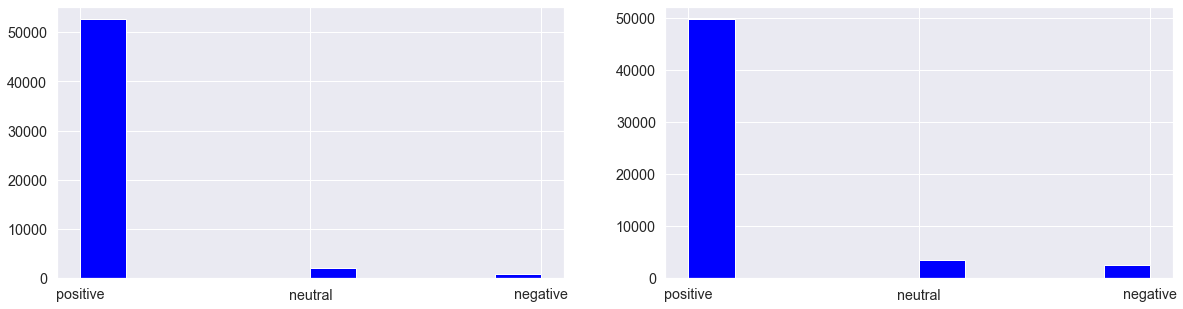

In [35]:
fig2, ax2 = plt.subplots(1,2, figsize=(20,5))
ax2[0].hist(x="sentiment_value", data=df, color="blue")
ax2[1].hist(x="comp_score", data=df, color="blue")
#sns.factorplot(x="sentiment_value", data=df, kind="count", palette="magma", ax=ax2[0])
#sns.factorplot(x="comp_score", data=df, kind="count", palette="magma", ax=ax2[1])

#### Input variable

To analyze the `review_body` variable we create a DataFrame named df_eda, where some basic statistics on the text variable are computed:

- `count_words`: number of words in the tweet
- `count_capital_words`: number of uppercase words are sometimes used to “shout” and express (negative) emotions
- `count_excl_quest_marks`: number of question or exclamation marks

In [37]:
# Creating a new variable with the reviews text
reviews = df["review_body"]

# Creating new variables for EDA DataFrame
count_words = reviews.apply(lambda x: len(re.findall(r'\w+', x)))
count_capital_words = reviews.apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', x)))
count_excl_quest_marks = reviews.apply(lambda x: len(re.findall(r'!|\?', x)))

# Storing the information in the EDA DataFrame
df_eda = pd.DataFrame({'count_words': count_words,
                       'count_capital_words': count_capital_words,
                       'count_excl_quest_marks': count_excl_quest_marks})

# Adding sentiment_value to df_eda
df_eda['sentiment_value'] = df.sentiment_value

In [39]:
#Encoding sentiment values into numbers
df_encoded = df
df_encoded["sentiment_value"] = df.sentiment_value.replace({"positive":3, "neutral":2, "negative": 1})
df_encoded["comp_score"] = df.comp_score.replace({"positive":3, "neutral":2, "negative": 1})
df_encoded[["comp_score", "sentiment_value"]] = df_encoded[["comp_score", "sentiment_value"]].astype(int)

In [42]:
df_eda["sentiment_encoded"] = df_encoded["sentiment_value"]
df_eda.head()

,count_words,count_capital_words,count_excl_quest_marks,sentiment_value,sentiment_encoded
0,100,0,2,positive,3
1,28,0,2,positive,3
2,28,0,1,positive,3
3,24,0,1,positive,3
4,41,0,2,positive,3


##### Distribution of the number of words in a review per target class

The histograms below show that the distribution of the number of words is rather low, with a mean of 63 words per review, a minimum of 5 words per review and a maximum of 3407 words per review. Negative and neutral reviews contain more words than positive ones.

In [43]:
pd.DataFrame(df_eda["count_words"].describe())

,count_words
count,55568.000000
mean,63.493575
std,56.149547
min,5.000000
25%,30.000000
50%,47.000000
75%,78.000000
max,3407.000000


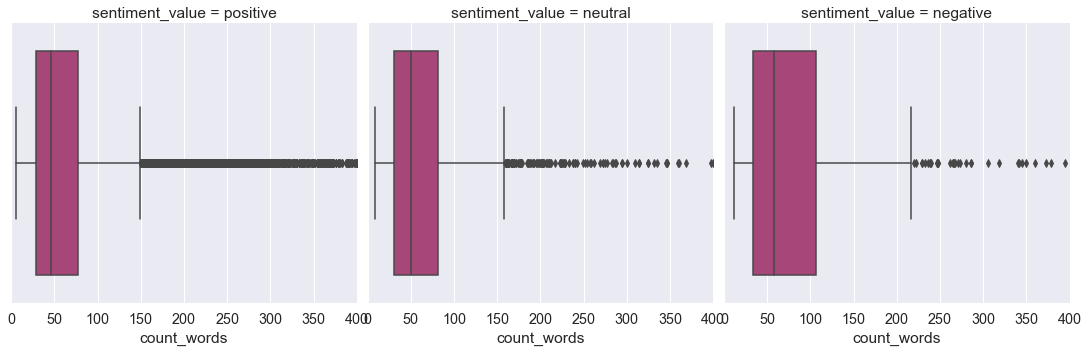

In [44]:
g = sns.factorplot(x="count_words", hue="sentiment_value", kind='box', col="sentiment_value", data=df_eda, palette="magma")
g.set(xlim=(0, 400))

##### Distribution of the number of capital words in a review per target class

Most of the reviews do not contain capitalized words and negative reviews seem to have a higher number of capital words.

In [45]:
pd.DataFrame(df_eda["count_capital_words"].describe())

,count_capital_words
count,55568.000000
mean,0.160866
std,0.951323
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,100.000000


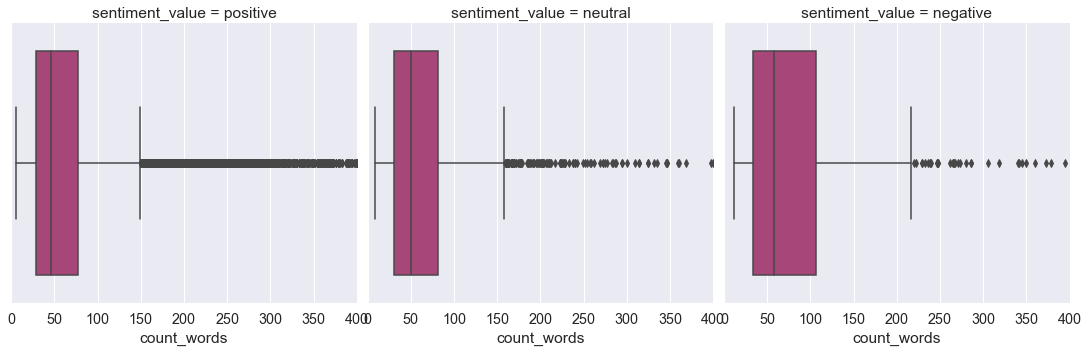

In [46]:
g = sns.factorplot(x="count_words", hue="sentiment_value", kind='box', col="sentiment_value", data=df_eda, palette="magma")
g.set(xlim=(0, 400))

##### Distribution of the number of exclamation and question marks in a review per target class

No correlation can be seen between these variables.

In [47]:
pd.DataFrame(df_eda["count_excl_quest_marks"].describe())

,count_excl_quest_marks
count,55568.000000
mean,0.618090
std,1.291924
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,35.000000


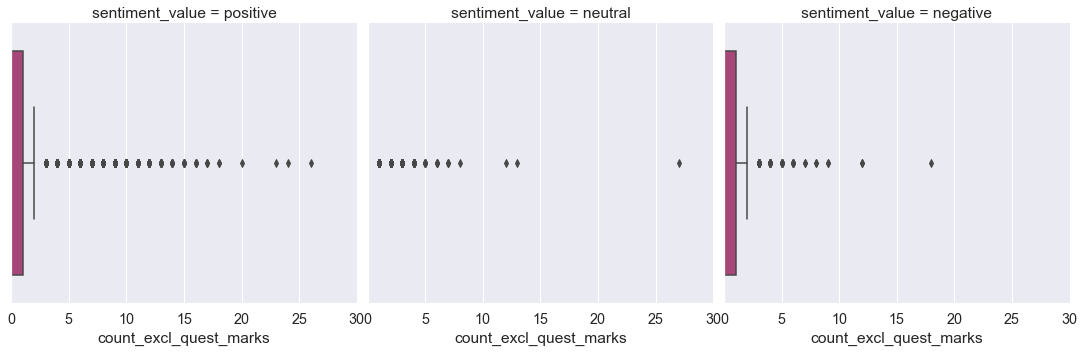

In [48]:
g = sns.factorplot(x="count_excl_quest_marks", hue="sentiment_value", kind='box', col="sentiment_value", data=df_eda, palette="magma")
g.set(xlim=(0, 30))

## Analysis of correlation between the two labelling approaches

In [49]:
# Calculating confusion matrix and creating a summary table
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(df["sentiment_value"], df["comp_score"])
mat_df = pd.DataFrame(mat) # Turning matrix into df
mat_df = mat_df.rename({0:"negative", 1: "neutral", 2:"positive"})
mat_df = mat_df.rename(columns={0: "negative", 1: "neutral", 2:"positive"})
mat_df["total"] = mat_df["negative"] + mat_df["neutral"] + mat_df["positive"] # Creating total colum
mat_df = mat_df.append(mat_df.sum(axis=0).rename('total')) # Creating total row
mat_df.index.names = ['human_approach'] 
columns=[('machine_approach', 'negative'), ('machine_approach', 'neutral'), ('machine_approach', 'positive'), ('machine_approach', 'total')]
mat_df.columns = pd.MultiIndex.from_tuples(columns)
mat_df

machine_approach                        
                       negative neutral positive  total
human_approach                                         
negative                    252     112      415    779
neutral                     307     299     1581   2187
positive                   1922    3023    47657  52602
total                      2481    3434    49653  55568

As it can be observed in the table above, the correlation in positive reviews is high. It is interesting to remark that a 6.5% of positive reviews are classified as negative by the NLTK method. Analysing the results of positive class in the table, we can conclude that if the algorithm NLTK detects more negative than positive sentences. 


## Analyzing word frequencies

### Creating Wordclouds for sentiment values

In [50]:
# Creating a DataFrame with the review and the sentiment_value
prep_reviews = pd.read_csv("../df_with_str_rev.csv", index_col=0)

# Filtering in order to obtain series of different sentiment values
positive_df = prep_reviews[prep_reviews["human_label"] == 3]
negative_df = prep_reviews[prep_reviews["human_label"] == 1]
neutral_df = prep_reviews[prep_reviews["human_label"] == 2]

# Creating text for different sentiment values
positive_df = positive_df.applymap(str)
positive_text = " ".join(review for review in pd.Series(positive_df["str_review"]))
negative_text = " ".join(review for review in pd.Series(negative_df["str_review"]))
neutral_text = " ".join(review for review in pd.Series(neutral_df["str_review"]))

print ("Total positive words:", (len(positive_text)))
print ("Total negative words:", (len(negative_text)))
print ("Total neutral words:", (len(neutral_text)))

Total positive words: 11387779
Total negative words: 215626
Total neutral words: 485713


In [51]:
wordcloud_n = WordCloud(max_font_size=40, max_words=100, background_color="white", colormap="gist_heat").generate(negative_text)

In [66]:
positive_text = positive_text.replace(",", " ")
positive_text = positive_text.replace("sagrada", "").replace("make", "").replace("insid", "").replace("tour", "").replace("sure", "").replace("book", "").replace("visit", "").replace("must", "").replace("barcelona", "").replace("buy", "").replace("onlin", "").replace("guid", "").replace("glass", "").replace("well", "").replace("window", "").replace("advanc", "")

In [67]:
# Creating and generate a word cloud image:
for i in tqdm(range(100)):
    wordcloud_p = WordCloud(max_font_size=40, max_words=100, background_color="white", colormap="Dark2").generate(positive_text)


(-0.5, 399.5, 199.5, -0.5)

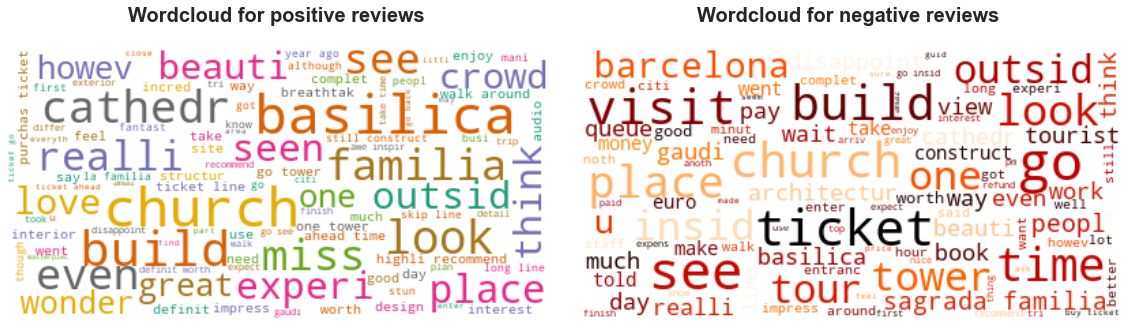

In [68]:
# Displaying the images:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
plt.subplots_adjust(wspace = 0.05)
ax[0].imshow(wordcloud_p, interpolation='bilinear')
ax[0].set_title("Wordcloud for positive reviews \n", fontsize=20, weight='bold')
ax[1].imshow(wordcloud_n, interpolation='bilinear')
ax[1].set_title("Wordcloud for negative reviews \n", fontsize=20, weight='bold')
ax.ravel()[0].set_axis_off()
ax.ravel()[1].set_axis_off()
plt.axis("off")

### Word frequencies for negative reviews

In [355]:
# Importing df with word counts 
human_negative = pd.read_csv("../negativeh_dict.csv", index_col=0)
machine_negative = pd.read_csv("../negativem_dict.csv", index_col=0)

#Selecting top 15 features per df
machine_negative = machine_negative.loc[:15]
human_negative = human_negative.loc[:15]

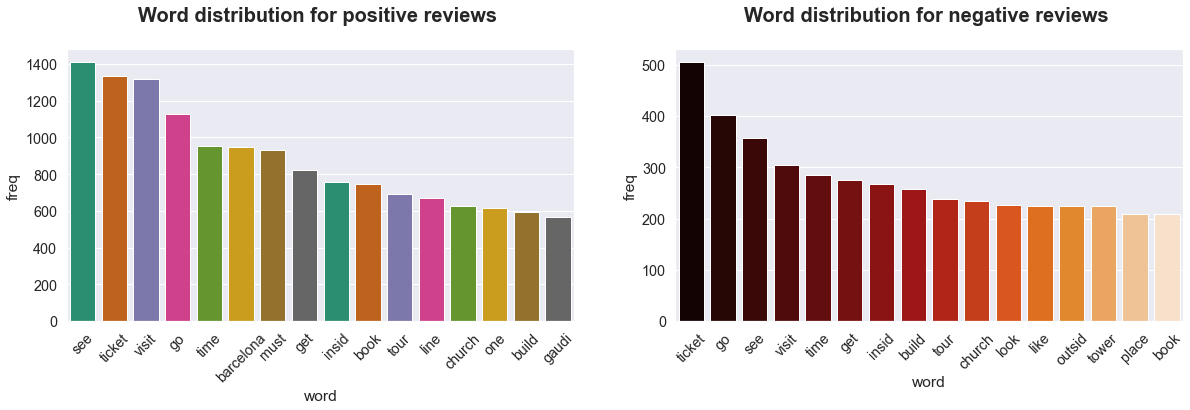

In [448]:
# Plotting the word frequencies
fig1, ax1 = plt.subplots(1, 2, figsize=(20, 5))
sns.barplot(x="word", y="freq", data=machine_negative, palette="Dark2", ax=ax1[0])
ax1[0].set_title("Word distribution for positive reviews \n", fontsize=20, weight='bold')
sns.barplot(x="word", y="freq", data=human_negative, palette="gist_heat", ax=ax1[1])
ax1[1].set_title("Word distribution for negative reviews \n", fontsize=20, weight='bold')

# Changing the rotation of the xticks
for i, ax in enumerate(fig1.axes):   # getting all axes of the fig object
     ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
        
plt.show()

#### Script to customize the wordcloud with Sagrada Família silhouette

In [525]:
# Creating mask from an image
sf_mask = np.array(Image.open("../Notebooks/icon_sf.png"))

In [526]:
# Values of 255 are pure white, whereas values of 1 are black.
def transform_format(val):
    if val == 1:
        return 255
    else:
        return val

In [527]:
# Transform your mask into a new one that will work with the function:
transformed_sf_mask = np.ndarray((sf_mask.shape[0],sf_mask.shape[1]), np.int32)

for i in range(len(sf_mask)):
    transformed_sf_mask[i] = list(map(transform_format, sf_mask[i]))

In [538]:
text_file = open("Output.txt", "w")
text_file.write(positive_text)
text_file.close()

(-0.5, 224.5, 224.5, -0.5)

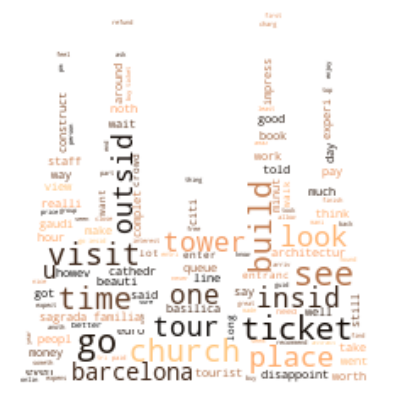

In [535]:
# Initializing the model
wc = WordCloud(max_font_size=20, mask=transformed_sf_mask, max_words=3000, 
                        background_color="white", colormap="copper").generate(negative_text)

# show
plt.figure(figsize=[7,7])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

(-0.5, 224.5, 224.5, -0.5)

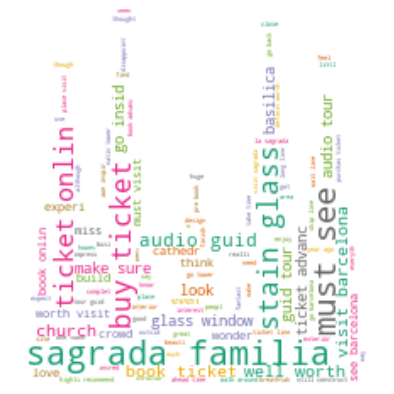

In [536]:
# Initializing the model
from wordcloud import WordCloud
wordcloud_positive = WordCloud(max_font_size=20, mask=transformed_sf_mask, max_words=4000, 
                        background_color="white", colormap="Dark2").generate(positive_text)

# show
plt.figure(figsize=[7,7])
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")